In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceM4/A-OKVQA", split = 'train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/964 [00:00<?, ?B/s]

(…)-00000-of-00002-c1d24de3bacb5e0c.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

(…)-00001-of-00002-6b4f3abe2dc385d0.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00000-of-00001-b2bd0de231b6326a.parquet:   0%|          | 0.00/60.4M [00:00<?, ?B/s]

(…)-00000-of-00001-d306bf3ad53b6618.parquet:   0%|          | 0.00/337M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17056 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1145 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6702 [00:00<?, ? examples/s]

In [ ]:
ds.features

{'image': Image(mode=None, decode=True, id=None),
 'question_id': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'choices': [Value(dtype='string', id=None)],
 'correct_choice_idx': Value(dtype='int8', id=None),
 'direct_answers': Value(dtype='string', id=None),
 'difficult_direct_answer': Value(dtype='bool', id=None),
 'rationales': [Value(dtype='string', id=None)]}

In [ ]:
import json

# Look at a single example with all its components
example = ds[0]
print(json.dumps({
    'question': example['question'],
    'choices': example['choices'],
    'correct_choice': example['choices'][example['correct_choice_idx']],
    'direct_answers': example['direct_answers'],
    'rationales': example['rationales']
}, indent=2))

# Count total questions
print(f"Total number of questions: {len(ds)}")

# See distribution of difficult vs easy questions
difficult_questions = ds.filter(lambda x: x['difficult_direct_answer'])
print(f"Number of difficult questions: {len(difficult_questions)}")

# Look at average number of choices per question
avg_choices = sum(len(x['choices']) for x in ds) / len(ds)
print(f"Average number of choices per question: {avg_choices:.2f}")

{
  "question": "What is the man by the bags awaiting?",
  "choices": [
    "skateboarder",
    "train",
    "delivery",
    "cab"
  ],
  "correct_choice": "cab",
  "direct_answers": "['ride', 'ride', 'bus', 'taxi', 'travelling', 'traffic', 'taxi', 'cab', 'cab', 'his ride']",
  "rationales": [
    "A train would not be on the street, he would not have luggage waiting for a delivery, and the skateboarder is there and not paying attention to him so a cab is the only possible answer.",
    "He has bags as if he is going someone, and he is on a road waiting for vehicle that can only be moved on the road and is big enough to hold the bags.",
    "He looks to be waiting for a paid ride to pick him up."
  ]
}
Total number of questions: 17056


Filter:   0%|          | 0/17056 [00:00<?, ? examples/s]

Number of difficult questions: 1544
Average number of choices per question: 4.00


### ***Make Calls to OpenAI***

In [ ]:
from google.colab import userdata
import os

# Set API key as environment variable
os.environ["OPENAI_API_KEY"] = userdata.get('openai-api')

In [ ]:
!pip install openai

### ***Process Data and Generate COTs for a small batch***

In [ ]:
def processdata(dataset, batch_size):
    """
    Process the first pipeline step: prepare dataset for CoT generation
    """
    # Take first batch_size samples
    batch = dataset.select(range(min(batch_size, len(dataset))))

    # Process each item into our desired format
    processed_data = []

    for item in batch:
        processed_item = {
            'question_id': item['question_id'],
            'image': item['image'],  # Keeping the PIL image object
            'question': item['question'],
            'choices': item['choices'],
            'correct_choice_idx': item['correct_choice_idx'],
            'direct_answers': eval(item['direct_answers']),  # Convert string to list
            'original_rationales': item['rationales'],
            # Fields to be filled in next steps
            'full_response': [],
            'cot_responses': [],  # Will hold 8 CoT reasoning chains
            'final_answers': [],  # Will hold 8 final answers
            'rankings': None      # Will hold judge's rankings
        }
        processed_data.append(processed_item)

    print(f"Processed {len(processed_data)} items")

    return processed_data

In [ ]:
def processdata2(dataset, start_idx, end_idx):
    """
    Process the first pipeline step: prepare dataset for CoT generation

    Args:
        dataset: Dataset containing image-question pairs and related information
        start_idx: Starting index for processing (inclusive)
        end_idx: Ending index for processing (exclusive)
    """
    # Validate indices
    if start_idx < 0 or end_idx > len(dataset) or start_idx >= end_idx:
        raise ValueError(f"Invalid range: start_idx={start_idx}, end_idx={end_idx}, dataset length={len(dataset)}")

    # Select the specified range
    batch = dataset.select(range(start_idx, end_idx))

    # Process each item into our desired format
    processed_data = []

    for item in batch:
        processed_item = {
            'question_id': item['question_id'],
            'image': item['image'],  # Keeping the PIL image object
            'question': item['question'],
            'choices': item['choices'],
            'correct_choice_idx': item['correct_choice_idx'],
            'direct_answers': eval(item['direct_answers']),  # Convert string to list
            'original_rationales': item['rationales'],
            # Fields to be filled in next steps
            'full_response': [],
            'cot_responses': [],  # Will hold 8 CoT reasoning chains
            'final_answers': [],  # Will hold 8 final answers
            'rankings': None      # Will hold judge's rankings
        }
        processed_data.append(processed_item)

    print(f"Processed {len(processed_data)} items (indices {start_idx} to {end_idx-1})")

    return processed_data

In [ ]:
processed_data = processdata(ds, 100)

Processed 100 items


In [ ]:
processed_data2 = processdata2(ds, 2001, 4001)

Processed 2000 items (indices 2001 to 4000)


In [ ]:
processed_data3 = processdata2(ds, 4001, 6001)

Processed 2000 items (indices 4001 to 6000)


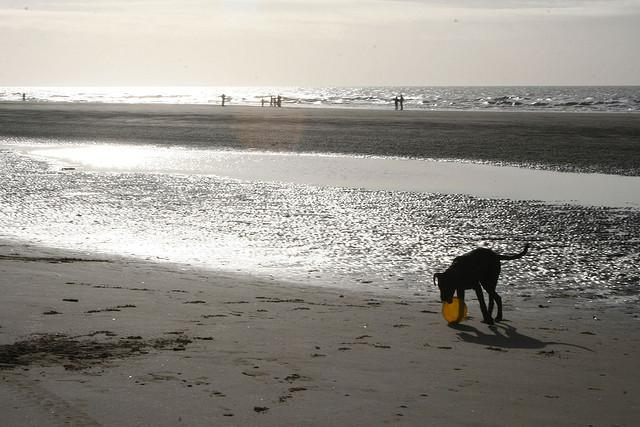

In [ ]:
processed_data3[1]['image']

In [ ]:
from IPython.display import Image, display

for item in processed_data[0:5]:
    print(item['question'])
    display(item['image'])

In [ ]:
!pip install tqdm

In [ ]:
from io import BytesIO
import base64

def encode_pil_image(pil_image):
    """Convert PIL image to base64 string"""
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

In [ ]:
encode_pil_image(processed_data[0]['image'])

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD22LbJGskZDoeQynIP4ipAM96yj4b0gtvSwjgkPWS2JgY/jGVp39kXUWfsusX8YzkJMUnX/wAfXd/49Wz9TJGrj2pcVlhddhI+fTrsY5ysluf0LinLqN9GCLjR7jj+K3ljlX+at/47U27FXRZl0yxnJMtnbsfUxDP51AdFt1U

In [ ]:
from openai import OpenAI

client = OpenAI()

In [ ]:

# Getting the base64 string
base64_image = encode_pil_image(processed_data[0]['image'])

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "What is in this image?",
        },
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          },
        },
      ],
    }
  ],
)

print(response.choices[0].message)

ChatCompletionMessage(content='The image shows a person standing on a street, facing away from the camera. They are holding a red bag and there are two pieces of luggage on the ground beside them. In the background, there are trees, parked cars, and a person walking on the sidewalk. The scene appears to be a suburban area during the day.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)


In [ ]:
from tqdm import tqdm

In [ ]:
def generate_cot_prompt(item):
    """
    Generate prompt for CoT response
    """
    choices_text = "\n".join([f"{i+1}. {choice}"
                             for i, choice in enumerate(item['choices'])])

    prompt = f"""Respond to the following user query in a comprehensive and detailed way. But first write down
      your internal thoughts. This must include your draft response and its evaluation. After this,
      write your final response after “<R>”.

      Question: {item['question']}

      Available choices:
      {choices_text}
      """
    return prompt

def generate_cot_responses(dataset, num_cots=4):
    """
    Generate multiple CoT responses for each question
    """
    for item in tqdm(dataset, desc="Generating CoT responses"):
        item['cot_responses'] = []
        item['final_answers'] = []
        base64_image = encode_pil_image(item['image'])

        for i in range(num_cots):
            prompt = generate_cot_prompt(item)

            # calling openai
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                  {
                    "role": "user",
                    "content": [
                      {
                        "type": "text",
                        "text": prompt,
                      },
                      {
                        "type": "image_url",
                        "image_url": {
                          "url":  f"data:image/jpeg;base64,{base64_image}",
                          "detail": "low"
                        },
                      },
                    ],
                  }
                ],
              )

            item['full_response'].append(response.choices[0].message.content )

    return dataset

In [ ]:
examplecot = generate_cot_prompt(processed_data[0])
print(examplecot)

Respond to the following user query in a comprehensive and detailed way. But first write down
your internal thoughts. This must include your draft response and its evaluation. After this,
write your final response after “<R>”.
    
Question: What is the man by the bags awaiting?

Available choices:
1. skateboarder
2. train
3. delivery
4. cab



In [ ]:
exampleresponses = generate_cot_responses(processed_data[0:10])
print(exampleresponses)

Generating CoT responses: 100%|██████████| 10/10 [07:08<00:00, 42.82s/it]

[{'question_id': '22MexNkBPpdZGX6sxbxVBH', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7AA5404A2B30>, 'question': 'What is the man by the bags awaiting?', 'choices': ['skateboarder', 'train', 'delivery', 'cab'], 'correct_choice_idx': 3, 'direct_answers': ['ride', 'ride', 'bus', 'taxi', 'travelling', 'traffic', 'taxi', 'cab', 'cab', 'his ride'], 'original_rationales': ['A train would not be on the street, he would not have luggage waiting for a delivery, and the skateboarder is there and not paying attention to him so a cab is the only possible answer.', 'He has bags as if he is going someone, and he is on a road waiting for vehicle that can only be moved on the road and is big enough to hold the bags.', 'He looks to be waiting for a paid ride to pick him up.'], 'full_response': ["### Internal Thoughts  \n\n**Draft Response Evaluation:**  \nThe image shows a man standing next to bags, and considering the context of transportation, there are a few possibl

### ***Batch Processing***

In [ ]:
# Adapting for Batch Processing

from google.colab import drive
drive.mount('/content/drive')

def create_batch_jsonl(processed_data, output_file="/content/drive/MyDrive//Berkeley-MIDS/NLP/final-project/batch_input.jsonl", num_cots=4):
    """
    Create JSONL file for batch processing
    """
    with open(output_file, 'w') as f:
        for idx, item in enumerate(processed_data):
            # Convert PIL image to base64
            base64_image = encode_pil_image(item['image'])

            # Create prompt
            prompt = generate_cot_prompt(item)

            # Create num_cots requests for each image-question pair
            for cot_idx in range(num_cots):
                request = {
                    "custom_id": f"item_{idx}_cot_{cot_idx}",
                    "method": "POST",
                    "url": "/v1/chat/completions",
                    "body": {
                        "model": "gpt-4o-mini",
                        "messages": [
                            {
                                "role": "user",
                                "content": [
                                    {
                                        "type": "text",
                                        "text": prompt
                                    },
                                    {
                                        "type": "image_url",
                                        "image_url": {
                                            "url": f"data:image/jpeg;base64,{base64_image}",
                                            "detail": "low"
                                        }
                                    }
                                ]
                            }
                        ]
                    }
                }
                f.write(json.dumps(request) + '\n')

def process_batch_results(results_file, processed_data):
    """
    Process the batch results and add them back to our dataset
    """
    data_map = {idx: item for idx, item in enumerate(processed_data)}

    with open(results_file, 'r') as f:
        for line in f:
            result = json.loads(line)
            item_id, cot_idx = map(int, result['custom_id'].replace('item_', '').replace('cot_', '').split('_'))

            if result['response']['status_code'] == 200:
                response_content = result['response']['body']['choices'][0]['message']['content']

                # Initialize lists if they don't exist
                if 'full_response' not in data_map[item_id]:
                    data_map[item_id]['full_response'] = [None] * 4

                # Store the response
                data_map[item_id]['full_response'][cot_idx] = response_content

    return list(data_map.values())

def run_batch_processing(processed_data, client):
    """
    Run the complete batch processing pipeline
    """
    print("Creating batch JSONL file...")
    create_batch_jsonl(processed_data)

    print("Uploading batch file...")
    batch_file = client.files.create(
        file=open("batch_input.jsonl", "rb"),
        purpose="batch"
    )

    print("Creating batch job...")
    batch = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )

    print(f"Batch created with ID: {batch.id}")
    print("You can check the status using:")
    print(f"client.batches.retrieve('{batch.id}')")

    return batch.id

Mounted at /content/drive


In [ ]:
create_batch_jsonl(processed_data)

In [ ]:
batch_file = client.files.create(
        file=open("batch_input.jsonl", "rb"),
        purpose="batch"
    )

In [ ]:
batch = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )

In [ ]:
print(f"Batch created with ID: {batch.id}")
print("You can check the status using:")
print(f"client.batches.retrieve('{batch.id}')")

Batch created with ID: batch_674ac7ac01a08190b6f4c6bd34ff2238
You can check the status using:
client.batches.retrieve('batch_674ac7ac01a08190b6f4c6bd34ff2238')


In [ ]:
processed_data = processdata(ds, 50)

Processed 50 items


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

output_file="/content/drive/MyDrive//Berkeley-MIDS/NLP/final-project/batch_input_test.jsonl"
num_cots=4

with open(output_file, 'w') as f:
    for idx, item in enumerate(processed_data):
        # Convert PIL image to base64
        base64_image = encode_pil_image(item['image'])

        # Create prompt
        prompt = generate_cot_prompt(item)

        # Create num_cots requests for each image-question pair
        for cot_idx in range(num_cots):
            request = {
                "custom_id": f"item_{idx}_cot_{cot_idx}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": "gpt-4o-mini",
                    "messages": [
                        {
                            "role": "user",
                            "content": [
                                {
                                    "type": "text",
                                    "text": prompt
                                },
                                {
                                    "type": "image_url",
                                    "image_url": {
                                        "url": f"data:image/jpeg;base64,{base64_image}",
                                        "detail": "low"
                                    }
                                }
                            ]
                        }
                    ]
                }
            }
            f.write(json.dumps(request) + '\n')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
file_path = "/content/drive/MyDrive//Berkeley-MIDS/NLP/final-project/batch_input_test.jsonl"
size_mb = os.path.getsize(file_path) / (1024 * 1024)
print(f"Batch file size: {size_mb:.2f} MB")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Batch file size: 14.44 MB


In [ ]:
batch_file = client.files.create(
        file=open("/content/drive/MyDrive//Berkeley-MIDS/NLP/final-project/batch_input_test.jsonl", "rb"),
        purpose="batch"
    )

In [ ]:
batch = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )

In [ ]:
print(f"Batch created with ID: {batch.id}")
print("You can check the status using:")
print(f"client.batches.retrieve('{batch.id}')")

Batch created with ID: batch_674b55a74d3c81909d7a91e89acb8546
You can check the status using:
client.batches.retrieve('batch_674b55a74d3c81909d7a91e89acb8546')


In [ ]:

client.batches.retrieve("batch_674b55a74d3c81909d7a91e89acb8546")

Batch(id='batch_674b55a74d3c81909d7a91e89acb8546', completion_window='24h', created_at=1732990375, endpoint='/v1/chat/completions', input_file_id='file-Ck4vpJ7FwY6kTUj945dE9K', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733076775, failed_at=None, finalizing_at=None, in_progress_at=1732990376, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=200))

In [ ]:
def process_all_data(dataset, batch_size=50, max_rows=None):
    """
    Process the dataset in batches of 50, up to max_rows if specified
    """
    total_size = len(dataset)
    if max_rows:
        total_size = min(total_size, max_rows)
        print(f"Will process {total_size} rows out of {len(dataset)}")

    num_batches = (total_size + batch_size - 1) // batch_size  # Ceiling division
    all_processed_batches = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, total_size)

        print(f"\nProcessing batch {i+1}/{num_batches} (items {start_idx} to {end_idx})")

        # Select this batch from dataset
        current_batch = dataset.select(range(start_idx, end_idx))

        # Process this batch using your existing function
        processed_batch = processdata(current_batch, len(current_batch))

        all_processed_batches.append(processed_batch)

        print(f"Completed batch {i+1}/{num_batches}")

    print(f"\nTotal batches processed: {len(all_processed_batches)}")
    print(f"Total items processed: {sum(len(batch) for batch in all_processed_batches)}")

    return all_processed_batches

# Use it like this to process only 150 rows in batches of 50:
processed_batches = process_all_data(ds, batch_size=50, max_rows=2000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def process_batches_through_api(processed_batches, client):
    """
    Create and submit batch jobs for each processed batch
    """
    batch_jobs = []

    for batch_idx, batch in enumerate(processed_batches):
        print(f"\nProcessing batch {batch_idx + 1}/{len(processed_batches)}")

        # Create JSONL file for this batch
        jsonl_filename = f"/content/drive/MyDrive/batch_input_{batch_idx}.jsonl"

        # Create the JSONL content for this batch
        with open(jsonl_filename, 'w') as f:
            for item_idx, item in enumerate(batch):
                base64_image = encode_pil_image(item['image'])
                prompt = generate_cot_prompt(item)

                for cot_idx in range(4):  # 4 CoT responses per item
                    request = {
                        "custom_id": f"batch_{batch_idx}_item_{item_idx}_cot_{cot_idx}",
                        "method": "POST",
                        "url": "/v1/chat/completions",
                        "body": {
                            "model": "gpt-4o-mini",
                            "messages": [
                                {
                                    "role": "user",
                                    "content": [
                                        {"type": "text", "text": prompt},
                                        {
                                            "type": "image_url",
                                            "image_url": {
                                                "url": f"data:image/jpeg;base64,{base64_image}",
                                                "detail": "low"
                                            }
                                        }
                                    ]
                                }
                            ]
                        }
                    }
                    f.write(json.dumps(request) + '\n')

        try:
            # Create batch file
            print(f"Uploading batch file {batch_idx + 1}...")
            batch_file = client.files.create(
                file=open(jsonl_filename, "rb"),
                purpose="batch"
            )

            # Create batch job
            print(f"Creating batch job {batch_idx + 1}...")
            batch_response = client.batches.create(
                input_file_id=batch_file.id,
                endpoint="/v1/chat/completions",
                completion_window="24h"
            )

            batch_jobs.append({
                'batch_idx': batch_idx,
                'batch_id': batch_response.id,
                'file_id': batch_file.id,
                'jsonl_file': jsonl_filename,
                'num_items': len(batch)  # Using the length of our processed batch
            })

            print(f"Successfully created batch job {batch_idx + 1} with ID: {batch_response.id}")

        except Exception as e:
            print(f"Error processing batch {batch_idx + 1}: {str(e)}")

    return batch_jobs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Create and submit the batch jobs
batch_jobs = process_batches_through_api(processed_batches, client)



### **Extracting Results from Batches**

In [ ]:
# prompt: read csv from google drive

import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in your Google Drive
file_path = '/content/drive/MyDrive/Berkeley-MIDS/NLP/final-project/batchids.csv'  # Replace with your actual file path

try:
  # Read the CSV file into a pandas DataFrame
  df = pd.read_csv(file_path)

  # Now you can work with the DataFrame 'df'
  print(df.head()) # Print the first few rows to verify

except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.EmptyDataError:
  print(f"Error: The CSV file at {file_path} is empty.")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}. Check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Mounted at /content/drive
   batch_number                                batch_id
0             1  batch_674b59825ebc8190afcf345e43f26f32
1             2  batch_674b5986abe48190b6f2def8dddd5eab
2             3  batch_674b598ba4688190bc52b85c2791cc71
3             4  batch_674b598e9b7c81908616f0f4685dcd4a
4             5  batch_674b5991863481909fbde704c5b6ce84


In [ ]:
for batchid in df['batch_id']:
  print(batchid)
  print(client.batches.retrieve(batchid))

In [ ]:
dfbatchids = df['batch_id']
dfbatchids

In [ ]:
from openai import OpenAI
client = OpenAI()

file_response = client.files.content("file-KEKfWeYep6inZSkDBWBFRR")
print(file_response.text)

In [ ]:
!pip install -q -U transformers==4.45.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.34.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 26.5 MB/s eta 0:00:00


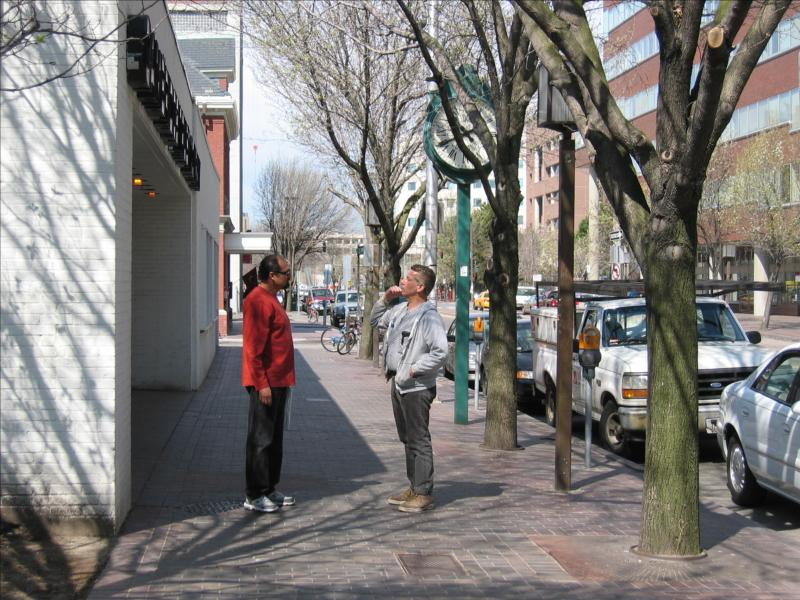

In [ ]:
import requests
from PIL import Image

image_url = "https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

In [ ]:
prompt = "USER: <image>\nRespond to the following user query in a comprehensive and detailed way. You can write down your thought process before responding. Write your thoughts after “Here is my thought process:” and write your response after “Here is my response:” What color is the clock?\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 500, "num_return_sequences": 4, "do_sample": True})

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [ ]:
print(outputs[0]["generated_text"])
print(outputs[1]["generated_text"])
print(outputs[2]["generated_text"])
print(outputs[3]["generated_text"])

USER:  
Respond to the following user query in a comprehensive and detailed way. You can write down your thought process before responding. Write your thoughts after “Here is my thought process:” and write your response after “Here is my response:” What color is the clock?
ASSISTANT: White color.
USER:  
Respond to the following user query in a comprehensive and detailed way. You can write down your thought process before responding. Write your thoughts after “Here is my thought process:” and write your response after “Here is my response:” What color is the clock?
ASSISTANT: Here is my thought process: I'm looking for a clock in the scene that is connected to a tree or possibly a traffic light. Although several clocks can be seen in the scene, none stand out as being connected to a tree or a traffic light.

Here is my response: There is no clock visible in the scene that is connected to a tree or traffic light. However, there are several clocks scattered throughout the area, a buildin

### ***Llava Inference***

In [ ]:
def generate_llava_cot_prompt(item):
    """
    Generate prompt for CoT response using LLaVa format
    """
    choices_text = "\n".join([f"{i+1}. {choice}"
                             for i, choice in enumerate(item['choices'])])

    prompt = f"""USER: <image>
Respond to the following user query in a comprehensive and detailed way. You can write down your thought process before responding. Write your thoughts after "Here is my thought process:" and write your response after "Here is my response:"

Question: {item['question']}

Available choices:
{choices_text}
ASSISTANT:"""
    return prompt

def generate_llava_cot_responses(dataset, pipe, num_cots=4):
    """
    Generate multiple CoT responses using LLaVa
    """
    for item in tqdm(dataset, desc="Generating CoT responses"):
        item['cot_responses'] = []
        item['final_answers'] = []

        # Get the prompt for this item
        prompt = generate_llava_cot_prompt(item)

        # Generate responses using LLaVa
        outputs = pipe(
            item['image'],  # LLaVa takes the image directly
            prompt=prompt,
            generate_kwargs={
                "max_new_tokens": 500,
                "num_return_sequences": num_cots,
                "do_sample": True
            }
        )

        # Store the responses
        item['full_response'] = []
        for output in outputs:
            item['full_response'].append(output)

    return dataset

In [ ]:
from tqdm import tqdm

In [ ]:
llavadataset = generate_llava_cot_responses(processed_data, pipe)


Generating CoT responses: 100%|██████████| 100/100 [51:44<00:00, 31.04s/it]


In [ ]:
llavadataset[0]

{'question_id': '22MexNkBPpdZGX6sxbxVBH',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'question': 'What is the man by the bags awaiting?',
 'choices': ['skateboarder', 'train', 'delivery', 'cab'],
 'correct_choice_idx': 3,
 'direct_answers': ['ride',
  'ride',
  'bus',
  'taxi',
  'travelling',
  'traffic',
  'taxi',
  'cab',
  'cab',
  'his ride'],
 'original_rationales': ['A train would not be on the street, he would not have luggage waiting for a delivery, and the skateboarder is there and not paying attention to him so a cab is the only possible answer.',
  'He has bags as if he is going someone, and he is on a road waiting for vehicle that can only be moved on the road and is big enough to hold the bags.',
  'He looks to be waiting for a paid ride to pick him up.'],
 'full_response': [{'generated_text': 'USER:  \nRespond to the following user query in a comprehensive and detailed way. You can write down your thought process before responding. Write 

In [ ]:
from google.colab import drive
import json
from copy import deepcopy

def prepare_for_json(dataset):
    """
    Create a JSON-serializable version of the dataset by removing/converting non-serializable items
    """
    # Create a deep copy to avoid modifying the original dataset
    json_safe_dataset = deepcopy(dataset)

    for item in json_safe_dataset:
        if 'image' in item:
            # Replace PIL image with a placeholder or remove it
            # You might want to save images separately if needed
            item['image'] = "PIL_IMAGE_OBJECT"  # or del item['image']

    return json_safe_dataset

# Mount Google Drive
drive.mount('/content/drive')

# Prepare the dataset
json_safe_dataset = prepare_for_json(llavadataset)

# Specify the file path in your Google Drive
file_path = '/content/drive/MyDrive/llavadataset.json'

# Save the modified dataset
with open(file_path, 'w') as f:
    json.dump(json_safe_dataset, f, indent=2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ***Faster Llava Model***

In [ ]:
pip install huggingface_hub[hf_transfer]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 70.1 MB/s eta 0:00:00


In [ ]:
# faster model loading
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [ ]:
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
# Load the model and processor
model = AutoModelForVision2Seq.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.bfloat16, device_map="auto")
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", do_image_splitting=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


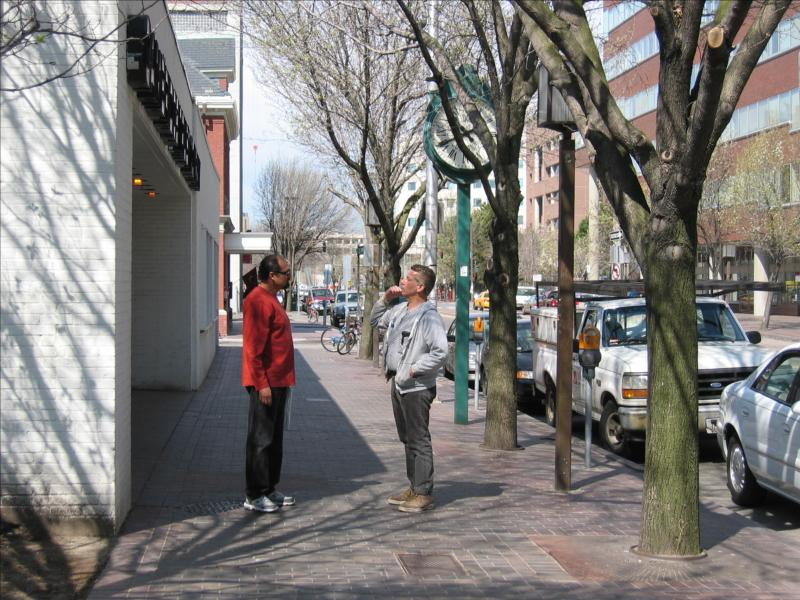

In [ ]:
import requests
from PIL import Image

image_url = "https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
# image = Image.open("1.jpg")
image

In [ ]:
conversation_1 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Respond to the following user query in a comprehensive and detailed way. But first write down your internal thoughts. This must include your draft response and its evaluation. Write your thoughts after “Here is my thought process:” and write your final response after “Here is my response:” What color is the clock?"},
        ],
    },
]

In [ ]:
prompt_1 = processor.apply_chat_template(conversation_1, add_generation_prompt=True)
prompts = [prompt_1]

# We can simply feed images in the order they have to be used in the text prompt
inputs = processor(images=[image], text=prompts, padding=True, return_tensors="pt").to(model.device, torch.float16)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=250, num_return_sequences = 8, do_sample= True, temperature=0.5)
processor.batch_decode(generate_ids, skip_special_tokens=True)

["USER:  \nRespond to the following user query in a comprehensive and detailed way. You can write down your thought process before responding. Write your thoughts after “Here is my thought process:” and write your response after “Here is my response:” What color is the clock? ASSISTANT: Here is my thought process: First, I need to identify the clock in the image. Since there are multiple clocks in the scene, I must focus on one that is clearly visible and distinguishable. Once I have found the clock, I must determine its color. If the clock is not clearly visible, I will need to look for other distinguishing features to identify the clock's color.\n\nHere is my response: The clock in the image is green.",
 'USER:  \nRespond to the following user query in a comprehensive and detailed way. You can write down your thought process before responding. Write your thoughts after “Here is my thought process:” and write your response after “Here is my response:” What color is the clock? ASSISTAN

In [ ]:
def generate_llava_cots(item):
    """
    Generate conversation format for LLaVa input
    """
    choices_text = "\n".join([f"{i+1}. {choice}"
                             for i, choice in enumerate(item['choices'])])

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": f"""Respond to the following user query in a comprehensive and detailed way. But first write down your internal thoughts. This must include your draft response and its evaluation. Write your thoughts after “Here is my thought process:” and write your final response after “Here is my response:”"

Question: {item['question']}

Available choices:
{choices_text}"""}
            ]
        }
    ]
    return conversation

def generate_llava_cot_responses(dataset, model, processor, num_cots=8):
    """
    Generate multiple CoT responses using LLaVa
    """
    for item in tqdm(dataset, desc="Generating CoT responses"):
        item['cot_responses'] = []
        item['final_answers'] = []

        # Create conversation format and apply chat template
        conversation = generate_llava_cots(item)
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

        # Process inputs
        inputs = processor(
            images=[item['image']],
            text=[prompt],
            padding=True,
            return_tensors="pt"
        ).to(model.device, torch.float16)

        # Generate responses
        generate_ids = model.generate(
            **inputs,
            max_new_tokens=250,
            num_return_sequences=num_cots,
            do_sample=True,
            temperature=0.5
        )

        # Decode and store responses
        item['full_response'] = processor.batch_decode(
            generate_ids,
            skip_special_tokens=True
        )

    return dataset

In [ ]:
processed_data = processdata(ds, 2000)

Processed 5 items


In [ ]:
from tqdm import tqdm

In [ ]:
llavadataset_2kto4k = generate_llava_cot_responses(processed_data2, model, processor)


Generating CoT responses: 100%|██████████| 2000/2000 [4:21:15<00:00,  7.84s/it]


In [ ]:
llavadataset_4kto6k = generate_llava_cot_responses(processed_data3, model, processor)


Generating CoT responses: 100%|██████████| 2000/2000 [4:19:46<00:00,  7.79s/it]


In [ ]:
from google.colab import drive
import json
from copy import deepcopy

def prepare_for_json(dataset):
    """
    Create a JSON-serializable version of the dataset by removing/converting non-serializable items
    """
    # Create a deep copy to avoid modifying the original dataset
    json_safe_dataset = deepcopy(dataset)

    for item in json_safe_dataset:
        if 'image' in item:
            # Replace PIL image with a placeholder or remove it
            # You might want to save images separately if needed
            item['image'] = "PIL_IMAGE_OBJECT"  # or del item['image']

    return json_safe_dataset

# Mount Google Drive
drive.mount('/content/drive')

# Prepare the dataset
json_safe_dataset = prepare_for_json(llavadataset_4kto6k)

# Specify the file path in your Google Drive
file_path = '/content/drive/MyDrive/llavadataset4kto6k.json'

# Save the modified dataset
with open(file_path, 'w') as f:
    json.dump(json_safe_dataset, f, indent=2)

Mounted at /content/drive


In [ ]:
processed_data4 = processdata2(ds, 6001, 8001)

In [ ]:
llavadataset_6kto8k = generate_llava_cot_responses(processed_data4, model, processor)


In [ ]:
from google.colab import drive
import json
from copy import deepcopy

def prepare_for_json(dataset):
    """
    Create a JSON-serializable version of the dataset by removing/converting non-serializable items
    """
    # Create a deep copy to avoid modifying the original dataset
    json_safe_dataset = deepcopy(dataset)

    for item in json_safe_dataset:
        if 'image' in item:
            # Replace PIL image with a placeholder or remove it
            # You might want to save images separately if needed
            item['image'] = "PIL_IMAGE_OBJECT"  # or del item['image']

    return json_safe_dataset

# Mount Google Drive
drive.mount('/content/drive')

# Prepare the dataset
json_safe_dataset = prepare_for_json(llavadataset_6kto8k)

# Specify the file path in your Google Drive
file_path = '/content/drive/MyDrive/llavadataset6kto8k.json'

# Save the modified dataset
with open(file_path, 'w') as f:
    json.dump(json_safe_dataset, f, indent=2)

In [ ]:
processed_data5 = processdata2(ds, 8001, 10001)

Processed 2000 items (indices 8001 to 10000)


In [ ]:
from google.colab import drive
import json
from copy import deepcopy

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
llavadataset_8kto10k = generate_llava_cot_responses(processed_data5, model, processor)


Generating CoT responses: 100%|██████████| 2000/2000 [4:22:47<00:00,  7.88s/it]


In [ ]:
from google.colab import drive
import json
from copy import deepcopy

def prepare_for_json(dataset):
    """
    Create a JSON-serializable version of the dataset by removing/converting non-serializable items
    """
    # Create a deep copy to avoid modifying the original dataset
    json_safe_dataset = deepcopy(dataset)

    for item in json_safe_dataset:
        if 'image' in item:
            # Replace PIL image with a placeholder or remove it
            # You might want to save images separately if needed
            item['image'] = "PIL_IMAGE_OBJECT"  # or del item['image']

    return json_safe_dataset

# Mount Google Drive
drive.mount('/content/drive')

# Prepare the dataset
json_safe_dataset = prepare_for_json(llavadataset_8kto10k)

# Specify the file path in your Google Drive
file_path = '/content/drive/MyDrive/llavadataset8kto10k.json'

# Save the modified dataset
with open(file_path, 'w') as f:
    json.dump(json_safe_dataset, f, indent=2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
llavadataset_2000[0]

{'question_id': '22MexNkBPpdZGX6sxbxVBH',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'question': 'What is the man by the bags awaiting?',
 'choices': ['skateboarder', 'train', 'delivery', 'cab'],
 'correct_choice_idx': 3,
 'direct_answers': ['ride',
  'ride',
  'bus',
  'taxi',
  'travelling',
  'traffic',
  'taxi',
  'cab',
  'cab',
  'his ride'],
 'original_rationales': ['A train would not be on the street, he would not have luggage waiting for a delivery, and the skateboarder is there and not paying attention to him so a cab is the only possible answer.',
  'He has bags as if he is going someone, and he is on a road waiting for vehicle that can only be moved on the road and is big enough to hold the bags.',
  'He looks to be waiting for a paid ride to pick him up.'],
 'full_response': ['USER:  \nRespond to the following user query in a comprehensive and detailed way. But first write down your internal thoughts. This must include your draft response a